![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
media = bikes.groupby('workingday').total.mean()
bikes.groupby('workingday').total.describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


En relación con la variable working se puede inferir que:

- Dado que existen más días laborales que días festivos/fin de semana, tenemos más registros de una clase que de otra
- En día festivo/fin de semana se alquilan en promedio 188 bicicletas, mientras que en día laboral se alquilan en promedio 193
- Hay mayor dispersión de los datos para la clase 1
- En el 50% de las veces, la cantidad de alquileres en día laboral es menor o igual a 151, frente a la cantidad en día festivo/fin de semana que es de 128.
- En día laboral, los registros muestran que se alcanzan valores máximos de 977 alquileres frente a 783 en día no laboral

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


Al analizar el número de alquileres de bicicletas en una hora determinada, encontramos que:

- En la madrugada hay un menor número de alquileres frente al resto del día
- Va creciendo conforme entra la mañana, incrementándose entre las 6 y 8 de la mañana. 
- Luego, hacia las 9 y 10 decae un poco, pero vuelve a tener una tendencia a crecer hasta las 6 de la tarde.
- Finalmente, comienza a bajar la demanda entrada la noche
- En horas como las 6 de la tarde vemos que oscila entre 23 y 977, siendo esta la hora en donde hay mayor demanda

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

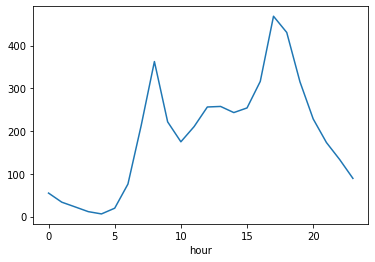

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

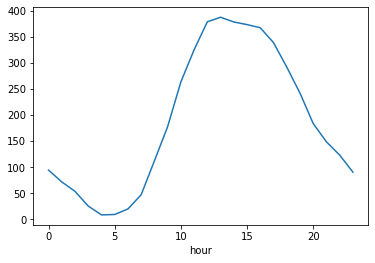

In [7]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
clase_0 = bikes[bikes['workingday'] == 0]
clase_0.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

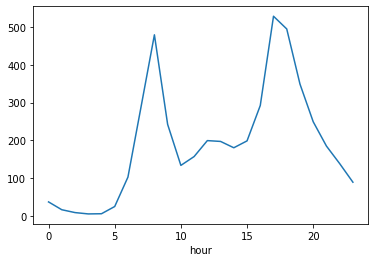

In [8]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
clase_1 = bikes[bikes['workingday'] == 1]
clase_1.groupby('hour').total.mean().plot()

Los gráficos nos muestran que:
1. La hora incide de manera importante en la cantidad de alquileres, siendo:
    a. En día laboral encontramos dos picos que se presentan en las horas más frecuentes de ingreso (8am) y salida del trabajo (6 pm). 
    b. Mientras que en fin de semana/día festivo encontramos que hay una tendencia creciente y constante desde el inicio de la mañana y hasta las 4 de la tarde.
2. En días laborales la demanda promedio logra alcanzar valores superiores a 500 en las 'horas pico', frente al fin de semana en donde los promedios superiores están alrededor de 380.
3. La cantidad promedio de alquileres a la media noche es menor en días laborales vs días festivos/fin de semana

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Separando los predictores de la variable de respuesta
x = bikes[["hour","workingday"]]
y = bikes['total']
XTrain, XTest, yTrain, yTest = train_test_split(x, y, test_size=0.33, random_state=0)

In [10]:
# Celda 3
modelo_3 = LinearRegression()
modelo_3.fit(X = x, y = y)
print("Intercept:", modelo_3.intercept_)
print("Coeficiente:", list(zip(x.columns, modelo_3.coef_.flatten(), )))

Intercept: 67.70595026191602
Coeficiente: [('hour', 10.49206282289374), ('workingday', 4.072486272904369)]


In [11]:
#función para calcular el mse
def mse(y,prediccion):
    mse = mean_squared_error(y, prediccion)
    return round(mse,1)

In [12]:
prediccion_3 = modelo_3.predict(XTest)
r2score_3 = r2_score(yTest,prediccion_3)
mse_arbol_3 = mse(yTest,prediccion_3)
r2score_3,mse_arbol_3

(0.1542683932647423, 27634.6)

Resultados del modelo:
Función objetivo = 67.70 + 10.49 hour + 4.07 workingday

1. El punto de corte está en 67.70 lo cual nos indica que para un día no laboral a la media noche (hora 0) el número previsto de bicicletas que se alquilan es de 67.70.
2. Al analizar los coeficientes, encontramos que en días no laborales a medida que avanza el día por cada hora que pasa, la cantidad de bicicletas alquiladas se incrementa en 10.49. 
3. En días laborales, además del incremento ya mencionado por hora hay una tasa de 4.07 bicicletas adicionales que se alquilan. 

Luego de entrenar el modelo y analizar los resultados encontramos que:

a. El modelo presume que a medida que aumenta una hora en el día, aumenta la demanda, lo cual deja de lado la "estacionalidad" que existe en la demanda de acuerdo a la hora y al tipo de día.

b. El modelo presenta un desempeño del 0.15 de acuerdo al r2 lo cual es un desempeño muy pobre con un error de 27.634

c. La regresión lineal simplifica demasiado el problema asumiendo que hay una relación lineal entre las variables, lo cual hace que este modelo no presente un buen desempeño para este problema en particular

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

Creamos funciones para:
1. Obtener los conjuntos de partición de cada variable
2. Calcular las predicciones

In [13]:
#Definimos las particiones para cada variable

def calcular_splits(x,variable):

    splits_variables = []
    if set(x.iloc[:,variable]) == {0,1}:
        splits_variables.append([1])
    else:
        percentiles = np.percentile(x.iloc[:,0], np.arange(0,100,100.0/8)).tolist()
        splits_variables.append(list(np.unique(percentiles)[1:]))

    return splits_variables[0]

In [14]:
#Funcion para definir las particiones para una variable
def conjuntos_particiones(x,y,split,variable):
    filter_v = x.iloc[:,variable]<split
    y_l = y.loc[filter_v]
    y_r = y.loc[~filter_v]
    x_l = x.loc[filter_v]
    x_r = x.loc[~filter_v]
    return y_l,y_r,x_l,x_r

In [15]:
#Calculamos las predicciones de cada lado del arbol
def predicciones(y_l,y_r):
    media_l = y_l.mean()
    media_r = y_r.mean()
    predicciones_l = [media_l]*len(y_l)
    predicciones_r = [media_r]*len(y_r)
    return predicciones_l,predicciones_r,media_l,media_r

In [16]:
#funcion para seleccionar el mejor split en cada variable

def best_split (x,y,variable):

    lista_mse = []
    lista_splits = []
    splits = calcular_splits(x,variable)
    for split in splits:
        y_izq,y_der,x_izq,x_der = conjuntos_particiones(x,y,split,variable)
        pred_l, pred_r,media_l,media_r = predicciones(y_izq,y_der)
        pred_l, pred_r,media_l,media_r = predicciones(y_izq,y_der)
        mse_l,mse_r = mse(y_izq,pred_l),mse(y_der,pred_r)
        n_l,n_r = len(y_izq),len(y_der)
        if len(lista_mse) == 0:
            lista_mse.append(mse_l)
            lista_mse.append(mse_r)
            lista_splits.append(split)
        elif mse_l < min(lista_mse) or mse_r < min(lista_mse):
            lista_mse[0] = mse_l
            lista_mse[1] = mse_r
            lista_splits[0] = split
    mejor_mse = min(lista_mse)
    mejor_split = lista_splits[0]
    mse_l = lista_mse[0]
    mse_r = lista_mse[1]
            
    return mejor_mse,mejor_split,mse_l,mse_r

Calculamos el MSE con el cual inicial el árbol:

In [20]:
prediccion_0 = [y.mean()]*len(y)
mse_0 = mse(y,prediccion_0)
print('MSE del nodo: ' +str(mse_0))
print('Número de observaciones del nodo: ' +str(len(x)))

MSE del nodo: 32810.3
Número de observaciones del nodo: 10886


Ejecutamos el código para comenzar con las particiones del árbol y evaluar los puntos de corte de todas las variables:

In [21]:
variables = list(x.columns.values)

splits_v1 = calcular_splits(x,0)
mejor_v1 = best_split (x,y,0)
splits_v2 = calcular_splits(x,1)
mejor_v2 = best_split (x,y,1)
if mejor_v1[0]<mejor_v2[0]:
    mse_f = mejor_v1[0]
    spl_f = mejor_v1[1]
    num_var = 0
    var = variables[num_var]
else:
    mse_f = mejor_v2[0]
    spl_f = mejor_v2[1]
    num_var = 1
    var = variables[num_var]




print('Predicción del nodo: ' +str(round(y.mean(),2)))

print('Punto de corte: Variable: '+str(var) + ' <= '+ str(spl_f))
print('MSE de la partición izquierda: ' +str(mejor_v1[0]))
print('MSE de la partición derecha: ' +str(mejor_v2[0]))

Predicción del nodo: 191.57
Punto de corte: Variable: hour <= 6.0
MSE de la partición izquierda: 945.8
MSE de la partición derecha: 30171.3


El resultado nos muestra que de las primeras 10.886 observaciones es posible hacer una partición en x <=6 reduciendo el MSE en la partición izquierda a 945.8.

Ejecutamos nuevamente para analizar la siguiente partición de la misma rama en donde tenemos un mse de 945.8

In [22]:
y_l,y_r,x_l,x_r = conjuntos_particiones(x,y,spl_f,num_var)
splits_v1 = calcular_splits(x_l,0)
mejor_v1 = best_split (x_l,y_l,0)
splits_v2 = calcular_splits(x_l,1)
mejor_v2 = best_split (x_l,y_l,1)
if mejor_v1[0]<mejor_v2[0]:
    mse_f = mejor_v1[0]
    spl_f = mejor_v1[1]
    num_var = 0
    var = variables[num_var]
else:
    mse_f = mejor_v2[0]
    spl_f = mejor_v2[1]
    num_var = 1
    var = variables[num_var]


pred_inicial = [y_l.mean()]*len(y_l)
mse_inicial = mse(y_l,pred_inicial)


print('Número de observaciones del nodo izq: ' +str(len(x_l)))
print('Predicción del nodo: ' +str(round(y_l.mean(),2)))

print('Número de observaciones del nodo der: ' +str(len(x_r)))
print('Predicción del nodo: ' +str(round(y_r.mean(),2)))

print('Punto de corte: Variable: '+str(var) + ' <= '+ str(spl_f))

print('MSE de la partición izquierda: ' +str(mejor_v1[0]))
print('MSE de la partición derecha: ' +str(mejor_v2[0]))

Número de observaciones del nodo izq: 2684
Predicción del nodo: 25.18
Número de observaciones del nodo der: 8202
Predicción del nodo: 246.03
Punto de corte: Variable: hour <= 4.0
MSE de la partición izquierda: 135.8
MSE de la partición derecha: 312.0


Se analizan 2684 observaciones, lo cual nos arroja que si se realiza una partición en la variable hour <= 4 reducimos el MSE a 135

In [23]:
y_l,y_r,x_l,x_r = conjuntos_particiones(x_l,y_l,spl_f,num_var)
splits_v1 = calcular_splits(x_l,0)
mejor_v1 = best_split (x_l,y_l,0)
splits_v2 = calcular_splits(x_l,1)
mejor_v2 = best_split (x_l,y_l,1)
if mejor_v1[0]<mejor_v2[0]:
    mse_f = mejor_v1[0]
    spl_f = mejor_v1[1]
    num_var = 0
    var = variables[num_var]
else:
    mse_f = mejor_v2[0]
    spl_f = mejor_v2[1]
    num_var = 1
    var = variables[num_var]


pred_inicial = [y_l.mean()]*len(y_l)
mse_inicial = mse(y_l,pred_inicial)


print('Número de observaciones del nodo izq: ' +str(len(x_l)))
print('Predicción del nodo: ' +str(round(y_l.mean(),2)))

print('Número de observaciones del nodo der: ' +str(len(x_r)))
print('Predicción del nodo: ' +str(round(y_r.mean(),2)))

print('Punto de corte: Variable: '+str(var) + ' <= '+ str(spl_f))

print('MSE de la partición izquierda: ' +str(mejor_v1[0]))
print('MSE de la partición derecha: ' +str(mejor_v2[0]))

Número de observaciones del nodo izq: 1790
Predicción del nodo: 31.18
Número de observaciones del nodo der: 894
Predicción del nodo: 13.16
Punto de corte: Variable: hour <= 3.0
MSE de la partición izquierda: 160.1
MSE de la partición derecha: 383.0


In [24]:
y_l,y_r,x_l,x_r = conjuntos_particiones(x_l,y_l,spl_f,num_var)
splits_v1 = calcular_splits(x_l,0)
mejor_v1 = best_split (x_l,y_l,0)
splits_v2 = calcular_splits(x_l,1)
mejor_v2 = best_split (x_l,y_l,1)
if mejor_v1[0]<mejor_v2[0]:
    mse_f = mejor_v1[0]
    spl_f = mejor_v1[1]
    num_var = 0
    var = variables[num_var]
else:
    mse_f = mejor_v2[0]
    spl_f = mejor_v2[1]
    num_var = 1
    var = variables[num_var]


pred_inicial = [y_l.mean()]*len(y_l)
mse_inicial = mse(y_l,pred_inicial)


print('Número de observaciones del nodo izq: ' +str(len(x_l)))
print('Predicción del nodo: ' +str(round(y_l.mean(),2)))

print('Número de observaciones del nodo der: ' +str(len(x_r)))
print('Predicción del nodo: ' +str(round(y_r.mean(),2)))

print('Punto de corte: Variable: '+str(var) + ' <= '+ str(spl_f))

print('MSE de la partición izquierda: ' +str(mejor_v1[0]))
print('MSE de la partición derecha: ' +str(mejor_v2[0]))

Número de observaciones del nodo izq: 1357
Predicción del nodo: 37.38
Número de observaciones del nodo der: 433
Predicción del nodo: 11.76
Punto de corte: Variable: workingday <= 1
MSE de la partición izquierda: 680.2
MSE de la partición derecha: 442.1


Analizando 1790 particiones observamos que haciendo una nueva partición ya no tendremos un mejor MSE por lo que en este punto terminaríamos las iteraciones

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [25]:
XTrain.shape

(7293, 2)

(0.6501337581022684, 8)

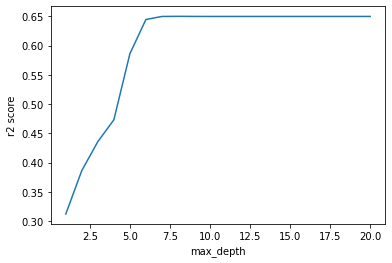

In [26]:
#calibrar el parámetro de máxima profunidad
max_depth_range = range(1,21)
r2_scores_5 = []
for depth in max_depth_range:
    rtree = DecisionTreeRegressor(max_depth=depth, random_state=1)
    r2_scores_5.append(cross_val_score(rtree,XTrain,yTrain,cv=10,scoring='r2').mean())   
plt.plot(max_depth_range,r2_scores_5)
plt.xlabel('max_depth')
plt.ylabel('r2 score')
sorted(zip(r2_scores_5,max_depth_range))[::-1][0]

(0.6223098117525746, 502)

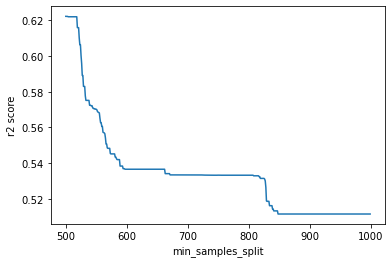

In [29]:
#número mínimo de observaciones que debe de tener un nodo para que pueda dividirse
min_samples_split = range(500,1000)
r2_scores = []
for dato in min_samples_split :
    rtree = DecisionTreeRegressor(max_depth= None, min_samples_split=dato, random_state=1)
    r2_scores.append(cross_val_score(rtree,XTrain,yTrain,cv=10,scoring='r2').mean())   
plt.plot(min_samples_split,r2_scores)
plt.xlabel('min_samples_split')
plt.ylabel('r2 score')
sorted(zip(r2_scores,min_samples_split))[::-1][0]

Al evaluar el número mínimo de observaciones que puede tener el árbol encontramos que con 502 observaciones se puede optimizar el desempeño del modelo, Entrenamos el modelo con una profunidad máxima de 8 y 502 observaciones ya que este es el parámetro optimizado que se identificó

In [30]:
# Celda 5
modelo_5 = DecisionTreeRegressor(max_depth=8,min_samples_split=502)
modelo_5.fit(XTrain,yTrain)
prediccion_5 = modelo_5.predict(XTest)
r2score_5 = r2_score(yTest,prediccion_5)
mse_arbol_5 = mse(yTest,prediccion_5)
r2score_5,mse_arbol_5

(0.6206996636825207, 12393.8)

Este modelo presenta un mejor desempeño comparado con el modelo obtenido a través de Regresión lineal en el punto # 3 ya que tiene un mejor r2 y un menor mse

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [31]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [32]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [33]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [34]:
# Celda 6
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
models = {'lr': LogisticRegression(),
          'dt': DecisionTreeClassifier()}

(0.6308888888888888, 2)

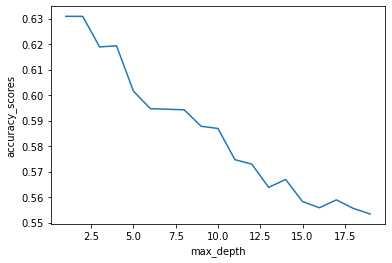

In [35]:
#calibrar el parámetro de máxima profunidad
max_depth_range = range(1,20)
accuracy_scores_6 = []
for depth in max_depth_range:
    clf_6 = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores_6.append(cross_val_score(clf_6,X_train,y_train,cv=10,scoring='accuracy').mean())   
plt.plot(max_depth_range,accuracy_scores_6)
plt.xlabel('max_depth')
plt.ylabel('accuracy_scores')
sorted(zip(accuracy_scores_6,max_depth_range))[::-1][0]

Observamos que la profundidad que mejor accuracy arroja es de 2

In [37]:
#Entrenamiento del árbol
modelo_6a = DecisionTreeClassifier(max_depth=2, random_state=1)
modelo_6a.fit(X_train, y_train)
ypred_6a = modelo_6a.predict(X_test)

from sklearn import metrics
f1_6a = metrics.f1_score(ypred_6a, y_test)
accuracy_6a = metrics.accuracy_score(ypred_6a, y_test)
f1_6a,accuracy_6a

(0.6448598130841121, 0.6453333333333333)

In [38]:
#Regresión logística
modelo_6b = LogisticRegression()
modelo_6b.fit(X_train, y_train)
ypred_6b = modelo_6b.predict(X_test)
f1_6b = metrics.f1_score(ypred_6b, y_test)
accuracy_6b = metrics.accuracy_score(ypred_6b, y_test)
f1_6b,accuracy_6b

(0.6096904441453566, 0.6133333333333333)

El análisis nos muestra que el árbol tiene un mejor desempeño  ya que es más preciso en identficiar cuándo una noticia es popular que el modelo de Regresión Logística. 

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [39]:
# 100 árboles de decisión donde max_depth = None
from sklearn.ensemble import BaggingClassifier
def votacion_mayoritaria(X_train,y_train,X_test,y_test,modelo):
    clf = BaggingClassifier(base_estimator=modelo, n_estimators=100, bootstrap=True,max_samples=300,
                            random_state=42, oob_score=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    metricas = metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)
    return metricas

In [40]:
m1 = votacion_mayoritaria(X_train,y_train,X_test,y_test,DecisionTreeClassifier(max_depth=None))
m2 = votacion_mayoritaria(X_train,y_train,X_test,y_test,DecisionTreeClassifier(max_depth=2))
m3 = votacion_mayoritaria(X_train,y_train,X_test,y_test,LogisticRegression())

In [41]:
print('Resultados Árbol votación mayoritaria con max_depth = None: F1_score: '+str(m1[0]) + ', Accuracy: '+str(m1[1]))
print('Resultados Árbol votación mayoritaria con max_depth = 2: F1_score: '+str(m2[0]) + ', Accuracy: '+str(m2[1]))
print('Resultados Regresión Logística votación ponderada: F1_score: '+str(m3[0]) + ', Accuracy: '+str(m3[1]))

Resultados Árbol votación mayoritaria con max_depth = None: F1_score: 0.6567567567567568, Accuracy: 0.6613333333333333
Resultados Árbol votación mayoritaria con max_depth = 2: F1_score: 0.631578947368421, Accuracy: 0.6453333333333333
Resultados Regresión Logística votación ponderada: F1_score: 0.6138211382113822, Accuracy: 0.62


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [42]:
# 100 árboles de decisión donde max_depth = None
def votacion_ponderada(X_train,y_train,X_test,y_test,modelo):
    clf = BaggingClassifier(base_estimator=modelo, n_estimators=100, bootstrap=True,max_samples=300,
                            random_state=42, n_jobs=-1, oob_score=True)

    # Predicción y desempeño al hacer votación ponderada
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

    # Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
    errors = np.zeros(clf.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

    for i in range(clf.n_estimators):
        oob_sample = ~clf.estimators_samples_[i]
        y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
        errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)

    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

    # Desempeño al hacer votación ponderada
    metricas = metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)
    return metricas

In [43]:
m4 = votacion_ponderada(X_train,y_train,X_test,y_test,DecisionTreeClassifier(max_depth=None))
m5 = votacion_ponderada(X_train,y_train,X_test,y_test,DecisionTreeClassifier(max_depth=2))
m6 = votacion_ponderada(X_train,y_train,X_test,y_test,LogisticRegression())

In [44]:
print('Resultados Árbol votación ponderada con max_depth = None: F1_score: '+str(m4[0]) + ', Accuracy: '+str(m4[1]))
print('Resultados Árbol votación ponderada con max_depth = 2: F1_score: '+str(m5[0]) + ', Accuracy: '+str(m5[1]))
print('Resultados Regresión Logística votación ponderada: F1_score: '+str(m6[0]) + ', Accuracy: '+str(m6[1]))

Resultados Árbol votación ponderada con max_depth = None: F1_score: 0.6631087391594397, Accuracy: 0.6633333333333333
Resultados Árbol votación ponderada con max_depth = 2: F1_score: 0.6324549237170597, Accuracy: 0.6466666666666666
Resultados Regresión Logística votación ponderada: F1_score: 0.6159029649595688, Accuracy: 0.62


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [45]:
arboles = ['Árbol 1 VM','Árbol 1 VP','Árbol 2 VM','Árbol 2 VP','RegLog VM','RegLog VP']
accuracy = [m1[1],m4[1],m2[1],m5[1],m3[1],m6[1]]
f1_score = [m1[0],m4[0],m2[0],m5[0],m3[0],m6[0]]
df = pd.DataFrame(list(zip(arboles,accuracy,f1_score)), columns = ['x','accuracy','f1_score'])
df

,x,accuracy,f1_score
0,Árbol 1 VM,0.661333,0.656757
1,Árbol 1 VP,0.663333,0.663109
2,Árbol 2 VM,0.645333,0.631579
3,Árbol 2 VP,0.646667,0.632455
4,RegLog VM,0.620000,0.613821
5,RegLog VP,0.620000,0.615903


En conclusión observamos que:

A nivel general se observa una ligera diferencia entre los métodos de votación mayoritaria y ponderada, siendo el de votación ponderada para la mayoría de las métricas el método que mejor desempeño presenta. 

El mejor desempeño lo encontramos en el modelo con el parámetro max_depth = None a nivel del accuracy
Sin embargo, cuando revisamos el f1_score el mejor desempeño se encuentra en el modelo con votación mayoritaria

La ventaja de los modleos de árboles es que nos permite interpretar cuáles de las características son más importantes para que una noticia sea popular, con mayor precisión indicando cuáles son los puntos de corte importantes para cada predictor

Para este caso en particular, nos interesa un modelo con mayor precisión ya que nos interesa que el modelo identifique los casos en los que la noticia es popular, no los casos en donde no lo es. Por esta razón, la recomendación es elegir el modelo con mejor accuracy